In [9]:
# HOG feature detection 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob 
import time 
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 
from skimage.feature import hog

from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_feature(img, orient, pix_per_cell, cell_per_block,
                   vis = False, feature_vec = True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features

def color_convert(image, cspace):
    feature_image = None
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image
    
def extract_features(imgs, cspace='RGB', orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for f in imgs:
        image = mpimg.imread(f)
        feature_image = color_convert(image, cspace)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_imag.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                    orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                           orient, pix_per_cell, cell_per_block,
                                           vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    
    # Return list of feature vectors
    return features


/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


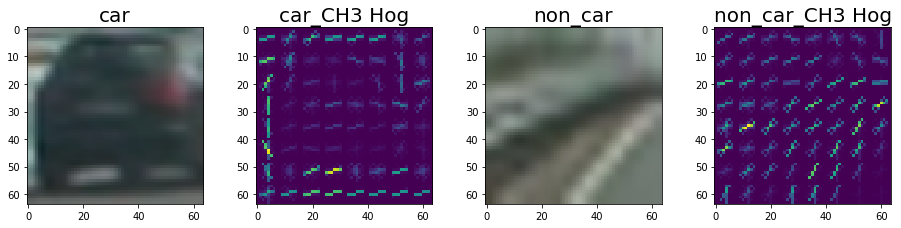

In [32]:
# test the feature extraction using an example 
car_img = mpimg.imread('./test_images/vehicles/vehicles/GTI_Left/image0020.png')
ncar_img = mpimg.imread('./test_images/non-vehicles/non-vehicles/GTI/image16.png')

car_feat_img = color_convert(car_img, 'HSV')
ncar_feat_img = color_convert(ncar_img, 'HSV')

_, car_hog = get_hog_feature(car_feat_img[:,:,2], orient=9,pix_per_cell=8, cell_per_block=2, 
                            vis = True, feature_vec = False)
_, ncar_hog = get_hog_feature(ncar_feat_img[:,:,2], orient=9,pix_per_cell=8, cell_per_block=2, 
                            vis = True, feature_vec = False)

# plot result 
plt.figure(1)
plt.subplots(1, 4, figsize = (12, 12))
# plt.subplots(1, 4 )
plt.subplot(141)
plt.title('car', fontsize = 20)
plt.imshow(car_img)
# plt.imshow(car_feat_img)

plt.subplot(142)
plt.title('car_CH3 Hog', fontsize = 20)
plt.imshow(car_hog)

plt.subplot(143)
plt.title('non_car', fontsize = 20)
plt.imshow(ncar_img)
# plt.imshow(ncar_feat_img)

plt.subplot(144)
plt.title('non_car_CH3 Hog', fontsize = 20)
plt.imshow(ncar_hog)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0., right=1., hspace=0.2, wspace=0.3)
plt.show()



In [53]:
# color feature 
# compute binned color features 
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# test 
def color_hist(img, nbins=32, bins_range = (0,256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [141]:

# extract features from image 
def single_img_features(img, color_space='RGB', spatial_size=(32,32),
                       hist_bins=32, orient=9, pix_per_cell=8,
                       cell_per_block=2, hog_channel=0,
                       spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define empty list to receive features
    img_features = []
    # 2) Apply color conversion
    feature_image = color_convert(img, color_space)
    # 3) Compute spatial features if flag is set 
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size = spatial_size)
        img_features.append(spatial_features)
    # 4) Compute Histogram features if flag is set 
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins = hist_bins)
        img_features.append(hist_features)
    # 5) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_feature(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_feature(feature_image[:,:,hog_channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True)
        img_features.append(hog_features)
    # print('len(spatial): ', len(spatial_features), 'len(hist): ', len(hist_features), 'len(hog): ', len(hog_features))
    # 6) Return concatenated array of features
    return np.concatenate(img_features)

def many_img_features(imgs, color_space='RGB', spatial_size=(32,32),
                       hist_bins=32, orient=9, pix_per_cell=8,
                       cell_per_block=2, hog_channel=0,
                       spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for img in imgs:
        feature_img = single_img_features(img, color_space, spatial_size,
                                         hist_bins, orient, pix_per_cell,
                                         cell_per_block, hog_channel,
                                          spatial_feat, hist_feat, hog_feat)
        features.append(feature_img)
    return features


number of cars:  8792  number of non-cars:  8968


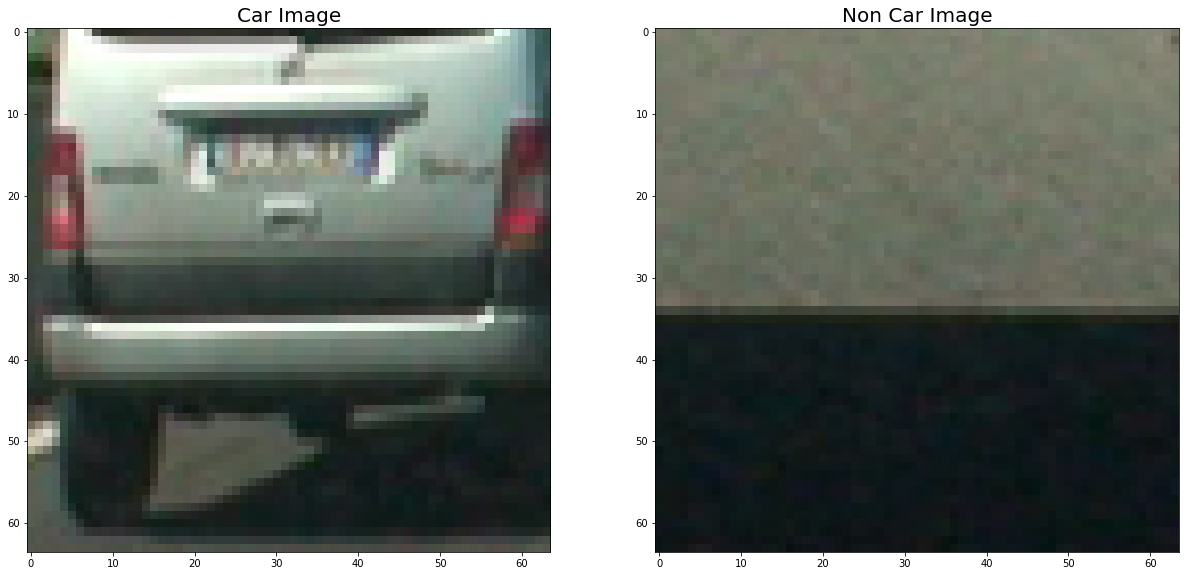

numer of car_imgs:  8792  number of not_car_imgs:  8968


In [55]:
# train a svm classifier 
# 1) prepare dataset 

import glob

# cars and notcars

cars = []
notcars = []

cars.append(glob.glob('./test_images/vehicles/vehicles/GTI_Left/*.png'))
cars.append(glob.glob('./test_images/vehicles/vehicles/GTI_Far/*.png'))
cars.append(glob.glob('./test_images/vehicles/vehicles/GTI_MiddleClose/*.png'))
cars.append(glob.glob('./test_images/vehicles/vehicles/GTI_Right/*.png'))
cars.append(glob.glob('./test_images/vehicles/vehicles/KITTI_extracted/*.png'))

notcars.append(glob.glob('./test_images/non-vehicles/non-vehicles/GTI/*.png'))
notcars.append(glob.glob('./test_images/non-vehicles/non-vehicles/Extras/*.png'))

cars = [item for sublist in cars for item in sublist]
notcars = [item for sublist in notcars for item in sublist]

print('number of cars: ', len(cars), ' number of non-cars: ', len(notcars))

# show an example 

car_img = mpimg.imread(cars[200])
non_car_img = mpimg.imread(notcars[200])

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
ax1.set_title('Car Image', fontsize = 20)
ax1.imshow(car_img)

ax2.set_title('Non Car Image', fontsize = 20)
ax2.imshow(non_car_img)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# load images 
car_imgs = []
notcar_imgs = []
for fimg in cars:
    img = mpimg.imread(fimg)
    car_imgs.append(img)
for fimg in notcars:
    img = mpimg.imread(fimg)
    notcar_imgs.append(img)

print('numer of car_imgs: ', len(car_imgs), ' number of not_car_imgs: ', len(notcar_imgs))

In [116]:
# 2) train the classifier 
from sklearn.preprocessing import StandardScaler


### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = many_img_features(car_imgs, color_space=color_space, spatial_size=spatial_size,
                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = many_img_features(notcar_imgs, color_space=color_space, spatial_size=spatial_size,
                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


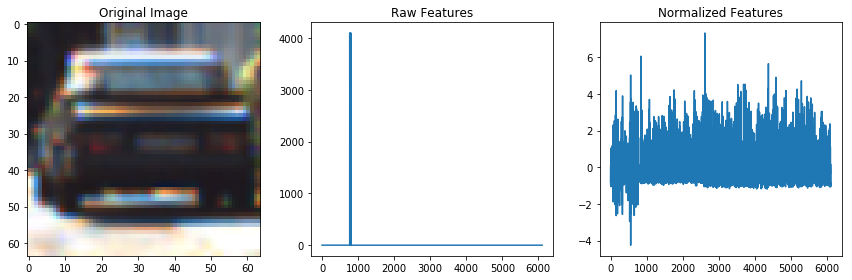

In [117]:
# Create an array stack of feature vectors
X = np.vstack((car_features,notcar_features)).astype(np.float64)
# Fit a per-column scaler 
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()


In [118]:
# label and shuffle dataset
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size = 0.2, random_state = 0)


In [119]:
# train and test svm classifier 
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# test 10 examples
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For these 10 labels: ', y_test[0:10])



Test accuracy of SVC =  0.9885
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]


In [137]:
image = mpimg.imread('./test_images/vehicles/vehicles/GTI_Left/image0020.png')

f1 = many_img_features([image], color_space=color_space, spatial_size=spatial_size,
                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

f2 = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                       cell_per_block=cell_per_block, hog_channel=hog_channel,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print('len(f1): ', len(f1[0]))
print('len(f2): ', len(f2))

len(spatial):  768 len(hist):  48 len(hog):  5292
len(spatial):  768 len(hist):  48 len(hog):  5292
len(f1):  6108
len(f2):  6108


/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [120]:
# slide_window 
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # define window area 
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    # compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*xy_overlap[0])
    ny_buffer = np.int(xy_window[1]*xy_overlap[1])
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    # initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = x_start_stop[0] + xs*nx_pix_per_step
            endx = startx + xy_window[0]
            starty = y_start_stop[0] + ys*ny_pix_per_step
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    return window_list 

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    

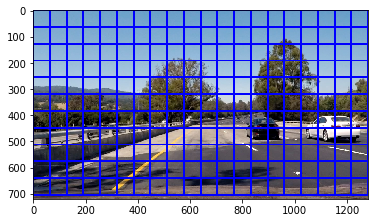

In [121]:
# test the sliding window method 
image = mpimg.imread('./test_images/test4.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None],
                      xy_window = (128, 128), xy_overlap = (0.5, 0.5))

window_img = draw_boxes(image, windows, color=(0,0,255), thick=6)
plt.imshow(window_img)
plt.show()


y: stop  90  start  0 y_span  90
< xy_window_y:  128


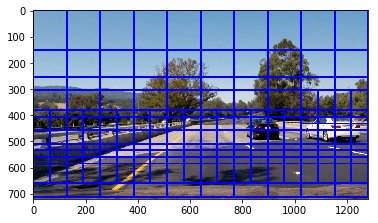

In [122]:
# slide window with multiple scale 

def multi_slide_window(image, level = 1, x_start_stop=[None, None], y_start_stop=[None, None],
                      xy_window = (128, 128), xy_overlap = (0.5, 0.5)):
    
      # define window area 
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image.shape[0]
    xss = x_start_stop
    yss = y_start_stop
    
    img = np.copy(image)
    m_windows = []
    for i in range(level):
        scale = 2**i
        size = (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale))
        img = cv2.resize(img, size)
        t_xss = [np.int(v/scale) for v in xss]
        t_yss = [np.int(v/scale) for v in yss]
        if t_xss[1] - t_xss[0] < xy_window[0] + 1:
            print('x: stop ', t_xss[1], ' start ', t_xss[0], 'x_span ', t_xss[1]-t_xss[0])
            print('< xy_window_x: ', xy_window[0])
            break
        if t_yss[1] - t_yss[0] < xy_window[1] + 1:
            print('y: stop ', t_yss[1], ' start ', t_yss[0], 'y_span ', t_yss[1]-t_yss[0])
            print('< xy_window_y: ', xy_window[1])
            break
        windows = slide_window(img, t_xss, t_yss,
                xy_window = xy_window, xy_overlap = xy_overlap)
        for w in windows:
            window = ((w[0][0]*scale, w[0][1]*scale), 
                      (w[1][0]*scale, w[1][1]*scale))
            m_windows.append(window)
    
    # m_windows = [window for sublist in m_windows for window in sublist]
    
    return m_windows

# test multi_slide window
multi_windows = multi_slide_window(image, level =4, x_start_stop=[None, None], y_start_stop=[None, None],
                      xy_window = (128, 128), xy_overlap = (0.5, 0.4))

window_img = draw_boxes(image, multi_windows[-100:], color=(0,0,255), thick=6)
plt.imshow(window_img)
plt.show()


In [139]:
# window generated
def search_windows(img, windows, clf, scaler, color_space='RGB',
                  spatial_size=(32,32), hist_bins=32, hist_range=(0,256),
                  orient=9, pix_per_cell=8, cell_per_block=2,
                  hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):
     # 1) Create an ampty list to receive positive detection windows
    on_windows = []
    for window in windows: 
        # 2) Extract the test window from original image 
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        
        # 3) Extract features for that window using single_img_feature      
        features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, 
                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
        
        # 4) Nomalization 
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        # 5) Predict 
        prediction = clf.predict(test_features)
        # 6) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    return on_windows

/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


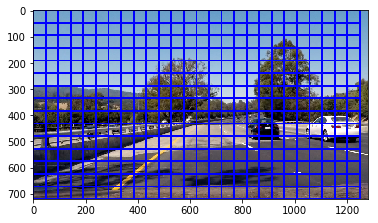

In [150]:
# test search window

y_start_stop = [None, None] # Min and max in y to search in slide_window()

image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)

windows = multi_slide_window(image, level = 1, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()





/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


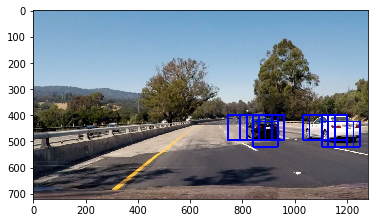

In [146]:
# run and test find_car

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = color_convert(img_tosearch, 'YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_feature(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_feature(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_feature(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    list_bbox = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # print('len(spatial): ', len(spatial_features), 'len(hist): ', len(hist_features), 'len(hog): ', len(hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                list_bbox.append(box)
                
    return draw_img, list_bbox
    
ystart = 400
ystop = 656
scale = 1.5

image = mpimg.imread('./test_images/test4.jpg')

out_img,_ = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()




/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


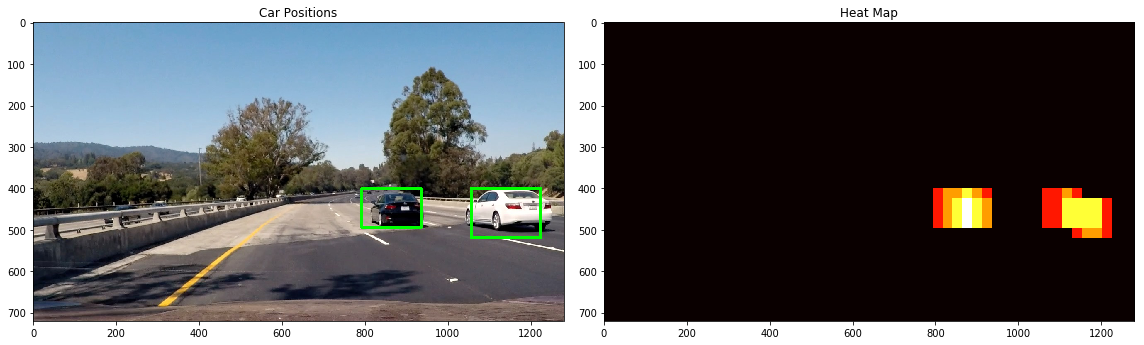

In [151]:
# heat map, label 
from scipy.ndimage.measurements import label 

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
                (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)
    return img


# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test4.jpg')
_, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize = (16, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [154]:
# handle video 
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    
    _, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img


output = 'output_images/test_video.mp4'
# clip2 = VideoFileClip('project_video.mp4').subclip(35, 45)
clip2 = VideoFileClip('test_video.mp4')
video_clip = clip2.fl_image(process_image)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 37.7 s, sys: 660 ms, total: 38.3 s
Wall time: 22.2 s


In [155]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>margin = self.margin
""".format(output))

In [156]:
output = 'output_images/project_video.mp4'
# clip2 = VideoFileClip('project_video.mp4').subclip(35, 45)
clip2 = VideoFileClip('project_video.mp4')
video_clip = clip2.fl_image(process_image)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [11:12<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 20min 7s, sys: 18.2 s, total: 20min 25s
Wall time: 11min 14s


In [157]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>margin = self.margin
""".format(output))